In [13]:
import os
import cv2
import numpy as np
import imutils
import urllib
import ssl
import copy
import urllib.request
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/CV/data')

#### Implementation

In [ ]:
cards  = []
for filename in ['lake.jpg', 'las.jpg', 'maki.jpg']:
    cards.append(cv2.imread(filename))
cards = np.array(cards, dtype='object')

In [ ]:
def get_markers(frame, imgH, imgW):
  arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_ARUCO_ORIGINAL)
  arucoParams = cv2.aruco.DetectorParameters_create()
  return cv2.aruco.detectMarkers(frame, arucoDict, parameters=arucoParams)

In [ ]:
def paste_image(corners, ids, imgW, imgH, source):
  ids = ids.flatten()
  refPts = []
  for i in (923, 1001, 241, 1007):
    j = np.squeeze(np.where(ids == i))
    corner = np.squeeze(corners[j])
    refPts.append(corner)
  (refPtTL, refPtTR, refPtBR, refPtBL) = refPts
  dstMat = [refPtTL[0], refPtTR[1], refPtBR[2], refPtBL[3]]
  dstMat = np.array(dstMat)
  (srcH, srcW) = source.shape[:2]
  srcMat = np.array([[0, 0], [srcW, 0], [srcW, srcH], [0, srcH]])
  (H, _) = cv2.findHomography(srcMat, dstMat)
  warped = cv2.warpPerspective(source, H, (imgW, imgH))

  mask = np.zeros((imgH, imgW), dtype="uint8")
  cv2.fillConvexPoly(mask, dstMat.astype("int32"), (255, 255, 255),
    cv2.LINE_AA)

  rect = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
  mask = cv2.dilate(mask, rect, iterations=2)

  maskScaled = mask.copy() / 255.0
  maskScaled = np.dstack([maskScaled] * 3)

  warpedMultiplied = cv2.multiply(warped.astype("float"), maskScaled)
  imageMultiplied = cv2.multiply(frame.astype(float), 1.0 - maskScaled)
  output = cv2.add(warpedMultiplied, imageMultiplied)
  output = output.astype("uint8")
  return output

In [ ]:
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

url = 'https://100.106.1.10:8080/shot.jpg'
context = ssl._create_unverified_context()

fps = 5
frameSize = (1280, 720)
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('test.avi', fourcc, fps, frameSize, isColor=True)

while True:
  k = cv2.waitKey(1)
  frameResp = urllib.request.urlopen(url, context=context)
  frameNp = np.array(bytearray(frameResp.read()), dtype=np.uint8)
  frame = cv2.imdecode(frameNp, -1)

  (imgH, imgW) = frame.shape[:2]
  (corners, ids, rejected) = get_markers(frame, imgH, imgW)
  corners = np.asanyarray(corners).astype(np.int)
  if len(corners) == 4:
    output = paste_image(corners, ids, imgW, imgH, cards[0])
  else:
    output = copy.deepcopy(frame)
    for pts in corners:
      pts = np.squeeze(pts)
      if len(pts) == 2:
        output = cv2.circle(output, tuple(pts), 3, (255, 0, 255), -1)
      elif len(pts) == 4:
        for pt in pts:
          output = cv2.circle(output, tuple(pt), 3, (255, 0, 255), -1)
  out.write(output)
  cv2.imshow('None', output)
  if k == 27: # Esc
      break
  if k == 32: 
    cards = np.roll(cards, 1) 
  # if k == 32: # Spacebar
  #   cv2.imwrite('img'+str(time.time())+'.png', output)

cv2.destroyAllWindows()
out.release()

### Tests

#### Inserting an image into a card from a standard distance

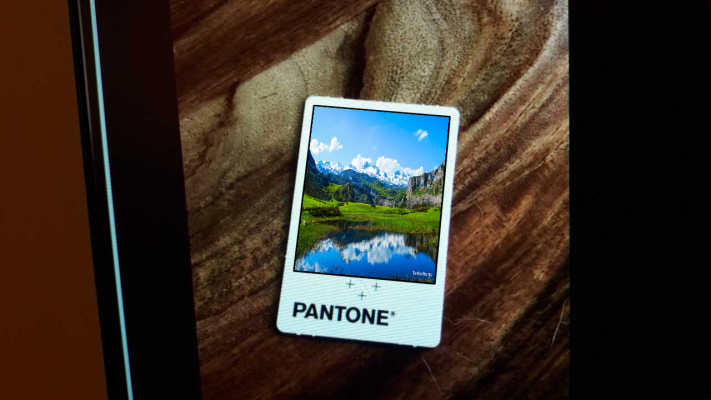

In [30]:
def show(filename):
  img = cv2.imread(filename[0])
  if len(filename) == 2:
    img = np.hstack([img, cv2.imread(filename[1])])
  resized = imutils.resize(img, height=400)
  cv2_imshow(resized)

show(['img5024033.png'])

#### Card slopes

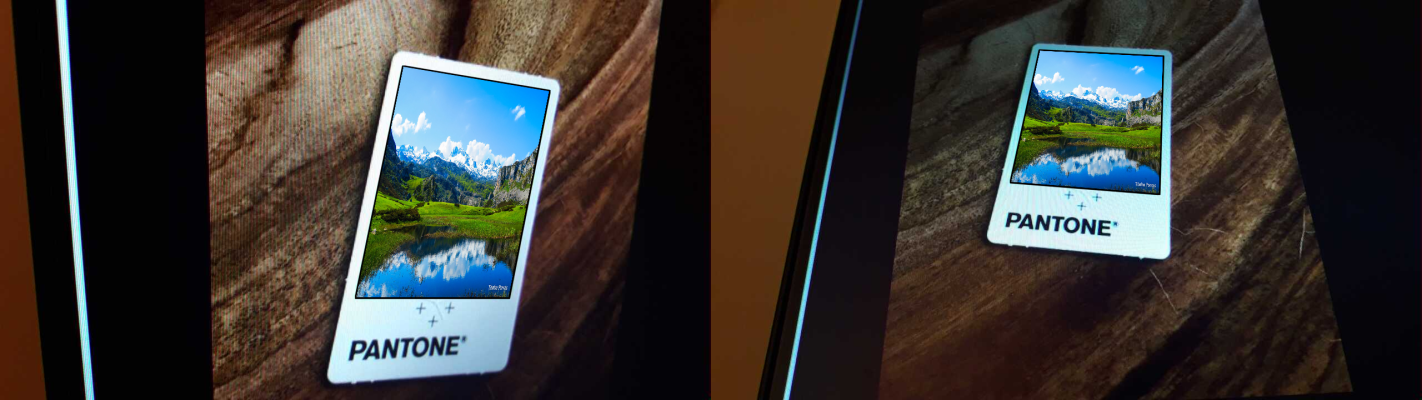

In [31]:
show(['img105448.png', 'img5915926.png'])

#### Card rotation

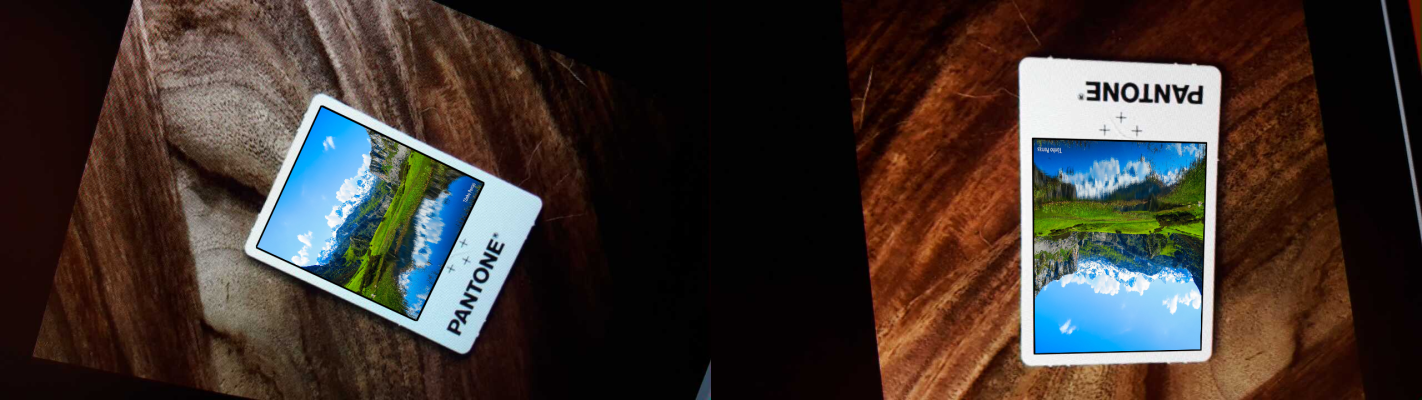

In [35]:
show(['img5162954.png', 'img9633808.png'])

#### Zoom in / out of the card

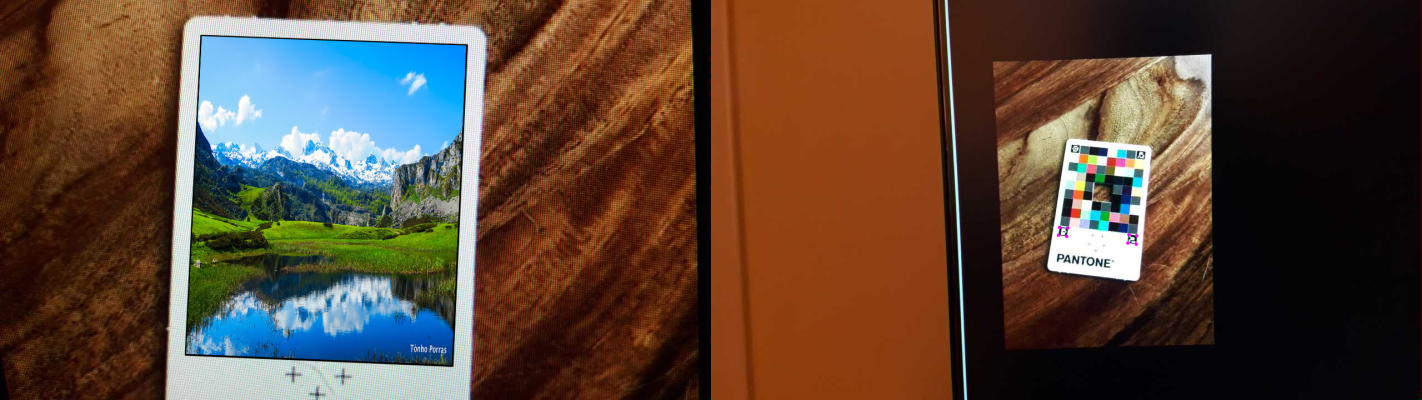

In [34]:
show(['img3632853.png', 'img0256603.png'])

#### Displaying two cards

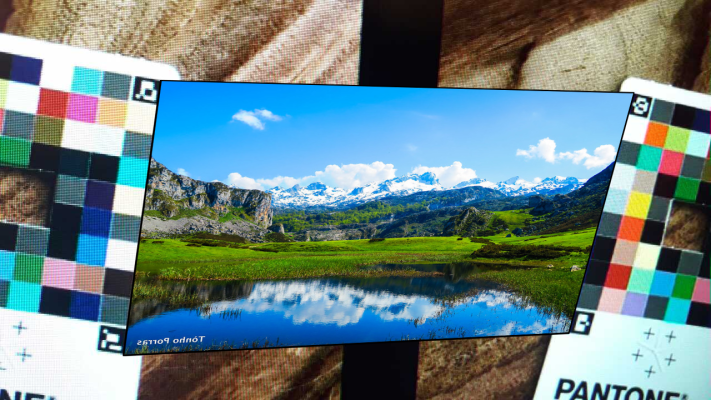

In [33]:
show(['img1517963.png'])

### Conclusions
- With card rotations of different angles, corner detection was not a problem.
- Also, the program is resistant to tilting the card with a jumper.
- Problems arose when moving the card away, while when zooming in, the corner markings were detected. 
- When more than one card appeared in the frame, the program did not check whether the markings belonged to the same card or to different ones and thus pasted the photo incorrectly.